<a href="https://colab.research.google.com/github/FrancisBian/SGD_test/blob/master/alg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloads MNIST

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = 'MNISTData'
INITIAL_PATH = 'Initial_SGD'
FINAL_PATH = 'Final_SGD'

# Hyperparameters
num_epochs = 50
num_classes = 10
batch_size = 100
learning_rate = 0.01
lambdaE = lambda epoch: 0.80 ** epoch

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Neural nets

In [72]:

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device will be run is: ")
print(device)

The device will be run is: 
cuda:0


In [0]:
model = ConvNet()
model.to(device)
torch.save(model.state_dict(), INITIAL_PATH)
criterion = nn.CrossEntropyLoss()

In [0]:
def generateAlg(model):
  # Loss and optimizers
  criterion = nn.CrossEntropyLoss()
  algorithm_list = []
  algorithm_list.append(torch.optim.Adam(model.parameters()))
  #algorithm_list.append(torch.optim.Adagrad(model.parameters()))
  algorithm_list.append(torch.optim.SGD(model.parameters(),lr=0.01))
  algorithm_list.append(torch.optim.SGD(model.parameters(),lr=0.01, dampening=0.9))
  algorithm_list.append(torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.93))
  algorithm_list.append(torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=0.0005))
  algorithm_list.append(torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.93, dampening=0.9,weight_decay=0.0005))
  algorithm_list.append(torch.optim.RMSprop(model.parameters()))
  algorithm_list.append(torch.optim.Adam(model.parameters()))
  return algorithm_list

Print model's state_dict and optimizer's state_dict

In [128]:
# Train the model
alg_final_weights = []
final_weights = []
for i in range(7):  
    print(i)
    model_temp = ConvNet()
    model_temp.load_state_dict(torch.load(INITIAL_PATH))
    algs = generateAlg(model_temp)
    optimizer = algs[i]
    model_temp.to(device)
    
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            # Run the forward pass
            outputs = model_temp(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Backprop and perform Adam optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            #if (i + 1) % 100 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                      (correct / total) * 100))
    # Test the model
    model_temp.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_temp(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    torch.save(model_temp.state_dict(), FINAL_PATH)
    alg_final_weights.append(FINAL_PATH)
    final_weights.append(model_temp.state_dict())

print(7)
model_temp = ConvNet()
model_temp.load_state_dict(torch.load(INITIAL_PATH))
algs = generateAlg(model_temp)
optimizer = algs[7]

model_temp.to(device)  
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(25):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # Run the forward pass
        outputs = model_temp(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        #if (i + 1) % 100 == 0:
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                  (correct / total) * 100))
# Test the model
model_temp.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_temp(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
torch.save(model_temp.state_dict(), FINAL_PATH)
alg_final_weights.append(FINAL_PATH)
final_weights.append(model_temp.state_dict())

    

0
Epoch [1/50], Step [600/600], Loss: 0.0211, Accuracy: 100.00%
Epoch [2/50], Step [600/600], Loss: 0.0534, Accuracy: 98.00%
Epoch [3/50], Step [600/600], Loss: 0.0466, Accuracy: 98.00%
Epoch [4/50], Step [600/600], Loss: 0.0178, Accuracy: 100.00%
Epoch [5/50], Step [600/600], Loss: 0.0532, Accuracy: 98.00%
Epoch [6/50], Step [600/600], Loss: 0.0200, Accuracy: 99.00%
Epoch [7/50], Step [600/600], Loss: 0.0574, Accuracy: 99.00%
Epoch [8/50], Step [600/600], Loss: 0.0164, Accuracy: 100.00%
Epoch [9/50], Step [600/600], Loss: 0.0581, Accuracy: 98.00%
Epoch [10/50], Step [600/600], Loss: 0.0168, Accuracy: 100.00%
Epoch [11/50], Step [600/600], Loss: 0.0222, Accuracy: 99.00%
Epoch [12/50], Step [600/600], Loss: 0.0276, Accuracy: 99.00%
Epoch [13/50], Step [600/600], Loss: 0.0088, Accuracy: 100.00%
Epoch [14/50], Step [600/600], Loss: 0.0089, Accuracy: 100.00%
Epoch [15/50], Step [600/600], Loss: 0.0933, Accuracy: 98.00%
Epoch [16/50], Step [600/600], Loss: 0.0326, Accuracy: 99.00%
Epoch [17

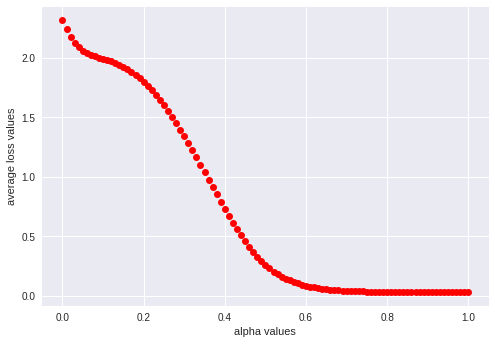

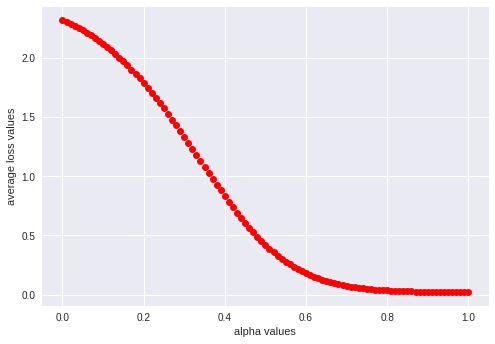

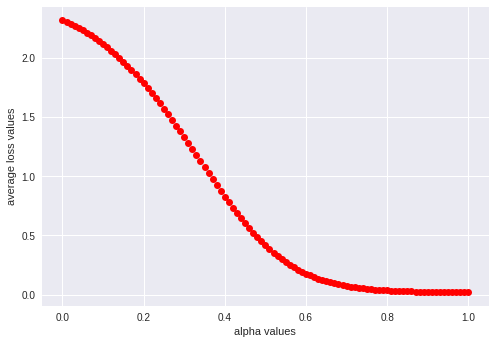

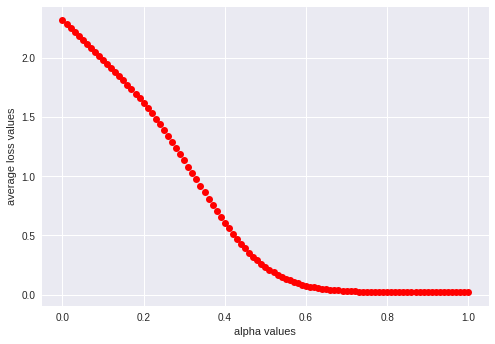

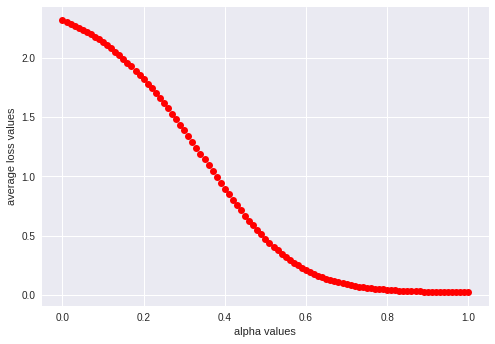

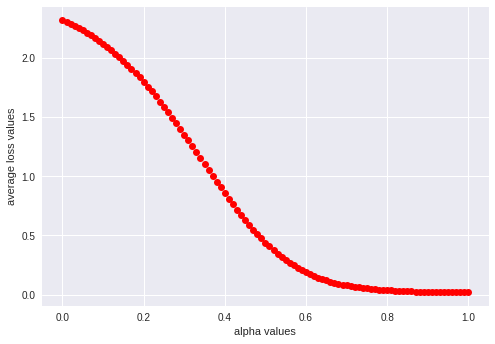

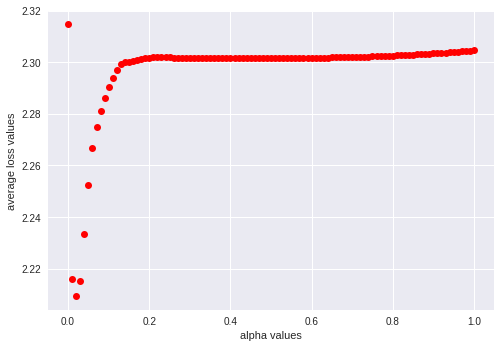

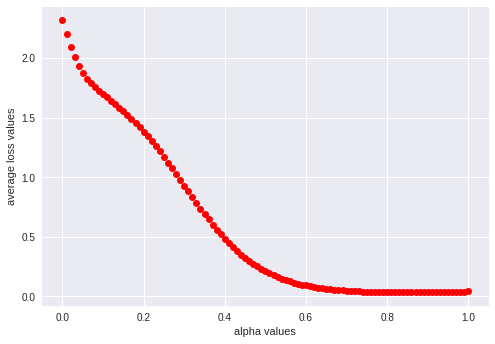

In [130]:
for i in range(8):
# computing research plot: N = 100

  N = 100
  torch.save(final_weights[i], FINAL_PATH)
  #for param_tensor in model.state_dict():
  #    print (model.state_dict()[param_tensor])

  initial = []
  final = []
  alphaList = []
  lossList = []
  model_i = ConvNet()
  model_i.load_state_dict(torch.load(INITIAL_PATH))
  for param_tensor_i in model_i.state_dict():
      initial.append(model_i.state_dict()[param_tensor_i])

  model_f = ConvNet()
  model_f.load_state_dict(torch.load(FINAL_PATH))   
  for param_tensor_f in model_f.state_dict():
      final.append(model_f.state_dict()[param_tensor_f])


  for i in range(N+1):
      alpha = i/N
      alphaList.append(alpha)
      tempList = []
      totalLoss = 0
      count = 0
      model_temp = ConvNet()

      #compute new temp parameter list
      for param1, param2 in zip(initial, final):
          temp1 = torch.mul(param1, 1-alpha)
          temp2 = torch.mul(param2, alpha)
          temp = temp1.add(temp2)
          tempList.append(temp)

      # feed the model with new temp parameters
      for item1, item2 in zip(model_temp.parameters(), tempList):
          item1.data = item2

      # get loss value
      model_temp.to(device)
      criterion = nn.CrossEntropyLoss()
      model_temp.eval()
      with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model_temp(images)
              loss = criterion(outputs, labels)
              totalLoss += loss.item()
              count += 1

      lossList.append(totalLoss / count)

  # plot
  plt.plot(alphaList, lossList, 'ro')
  plt.xlabel('alpha values')
  plt.ylabel('average loss values')
  plt.show()